# Initialization

In [ ]:
import os
import sys

!pip install rasterio
!pip install fiona
!pip install pyproj
!pip install gdal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 78.9 MB/s eta 0:00:00


In [ ]:
!pip install ecoscape-connectivity


In [ ]:
import numpy as np
import torch
from torch import nn
import torch.functional as F
import scipy.ndimage as nd
import matplotlib.pyplot as plt

In [ ]:
from ecoscape_connectivity import analyze_tile_torch

In [ ]:
if(torch.cuda.is_available()):
    torch.cuda.set_device(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


# Simulated landscapes

## Test habitats and terrains

In [ ]:
def simulate(hab, ter,
             seed_density=4.0, batch_size=5, total_spreads=25, num_simulations=400, hop_length=1):
    """
    Function that makes simulating and displaying repopulation easier.
    """

    # analyze_tile expects the habitat to be of shape (1, w, h)
    if np.ndim(hab) == 2:
        hab = np.expand_dims(hab, axis=0)

    repopulate = analyze_tile_torch(device=device,
            produce_gradient=True,
            seed_density=seed_density,
            batch_size=batch_size,
            total_spreads=total_spreads,
            num_simulations=num_simulations,
            hop_length=hop_length)

    repop, grad = repopulate(hab, ter)

    # a bit of reshaping for displaying with matplotlib
    hab = np.sum(hab, 0)
    repop = np.sum(repop.detach().cpu().numpy(), 0)
    grad = np.log2(1 + np.sum(grad.detach().cpu().numpy(), 0))

    return repop, grad

In [ ]:
def draw_circle(hab, y, x, r):
    return np.maximum(hab, (X - x) ** 2 + (Y - y) ** 2 < r ** 2)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

In [ ]:
import matplotlib.cm as cm

inferno = cm.inferno(np.linspace(0, 1, 256))
last_color = inferno[-1]
last_color

array([0.988362, 0.998364, 0.644924, 1.      ])

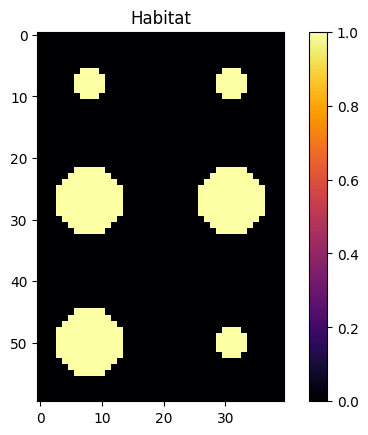

In [ ]:
# habitat for testing resistance vs dispersal distance
Xdim = 40
Ydim = 60

Y, X = np.meshgrid(range(0, Xdim), range(0, Ydim))

hab = np.zeros((Ydim, Xdim))
hab = draw_circle(hab, 31, 50, 2.5) # c1
hab = draw_circle(hab, 31, 27, 5.5) # c2
hab = draw_circle(hab, 31, 8, 2.5) # c3
hab = draw_circle(hab, 8, 8, 2.5) # c4
hab = draw_circle(hab, 8, 27, 5.5) # c5
hab = draw_circle(hab, 8, 50, 5.5) # c6

plt.imshow(hab, cmap='inferno')
plt.colorbar()
plt.title('Habitat')
plt.show()

In [ ]:
cdict = {
    'red': (
        (0.0,  0.0, 0.0),
        (0.95,  0.0, 0.0),
        (1.0, 0.4, 0.4),
    ),
    'green': (
        (0.0,  0.0, 0.0),
        (0.95,  0.3, 0.3),
        (1.0, 1, 1),
    ),
    'blue': (
        (0.0,  0.0, 0.0),
        (0.95,  0.0, 0.0),
        (1.0,  0.4, 0.4),
    )
}
habitat_cmap = LinearSegmentedColormap('habitat_cmap', cdict)

In [ ]:
cdict = {
    'red': (
        (0.0,  0.0, 0.0),
        (0.95,  0, 0),
        (1.0, 0.5, 0.5),
    ),
    'green': (
        (0.0,  0.0, 0.0),
        (0.95,  0.3, 0.3),
        (1.0, 1.0, 1.0),
    ),
    'blue': (
        (0.0,  0.0, 0.0),
        (0.95,  0, 0),
        (1.0,  0.5, 0.5),
    )
}
habitat_cmap = LinearSegmentedColormap('habitat_cmap', cdict)

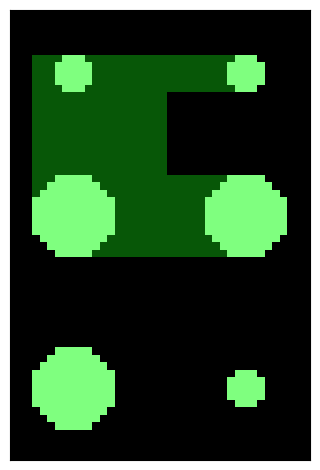

In [ ]:
corridor = 0.95
ter = np.zeros_like(hab)
ter[6:25, 3:21] = corridor
ter[6:11, 10:33] = corridor
ter[22:33, 10:32] = corridor

total = np.maximum(hab, ter)
plt.imshow(total, cmap=habitat_cmap)
# plt.title('Habitat and terrain')
# Remove x tiks from the plot
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("artificial_landscape.pdf", bbox_inches="tight", format="pdf")

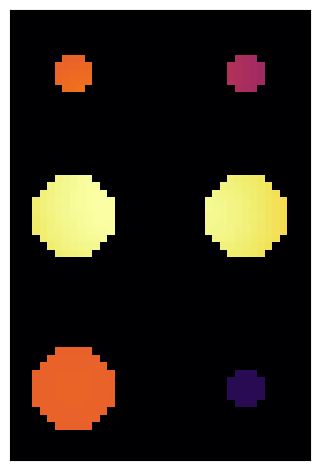

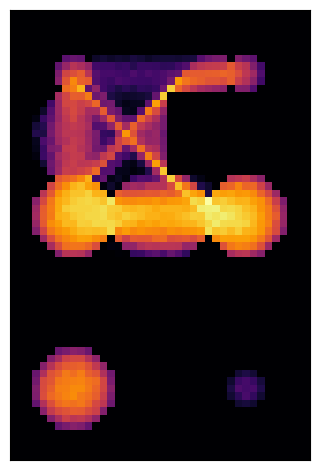

In [ ]:
repop, grad = simulate(hab, ter,
             seed_density=4.0, batch_size=200, total_spreads=40, num_simulations=10000, hop_length=1)
plt.imshow(repop, cmap='inferno')
# plt.colorbar(shrink=0.5)
# plt.title("Repopulation")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("connectivity.pdf", bbox_inches="tight", format="pdf")
plt.show()
plt.imshow(grad, cmap='inferno')
# plt.colorbar(shrink=0.5)
# plt.title("Flow")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("flow.pdf", bbox_inches="tight", format="pdf")
plt.show()